In [40]:
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [41]:
# df = pdr.get_data_tiingo('AAPL', api_key='49dbc05de2e9e0d3f3c2099ed73bdbb34a555ab5')
# df.to_csv('AAPL.csv')
# df.head()
# df.tail()

In [42]:
# Define dates: last 10 years
# end_date = datetime.today()
# start_date = end_date - timedelta(days=10*365)  # roughly 10 years

end_date = "2020-05-23"
start_date = "2015-05-27"

# Download historical stock data
df = yf.download('AAPL', start=start_date, end=end_date)

# Preview the data
print(df.head())
print(df.tail())

C:\Users\Amarjeet\AppData\Local\Temp\ipykernel_24848\2240883948.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-05-27  29.510450  29.559620  29.065695  29.130507  183332800
2015-05-28  29.452339  29.490333  29.300363  29.470219  122933200
2015-05-29  29.117092  29.378582  29.032162  29.329413  203538000
2015-06-01  29.175196  29.365169  29.065685  29.117088  128451200
2015-06-02  29.045580  29.202027  28.902542  29.023229  134670400
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-05-18  76.379898  76.753360  75.254671  75.945816  135178400
2020-05-19  75.938553  77.243233  75.907026  76.396887  101729600
2020-05-20  77.415413  77.485735  76.758214  76.797016  111504800
2020-05-21  76.838249  77.817978  76.600590  77.277186  102688800
2020-05-22

In [43]:
df1 = df.reset_index()['Close']

In [44]:
df1.shape

(1258, 1)

In [45]:
df1

Ticker,AAPL
0,29.510450
1,29.452339
2,29.117092
3,29.175196
4,29.045580
...,...
1253,76.379898
1254,75.938553
1255,77.415413
1256,76.838249


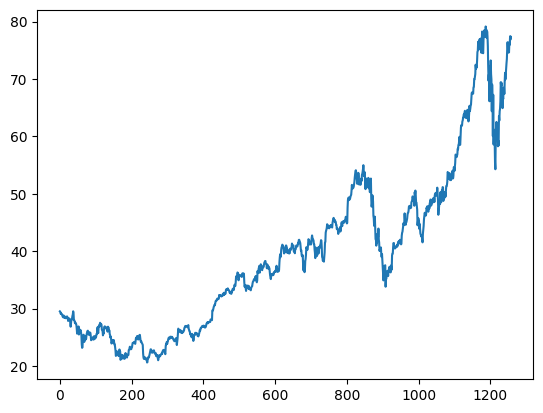

In [46]:
import matplotlib.pyplot as plt
df["Day_Number"] = range(len(df))
plt.plot(df["Day_Number"], df["Close"])

In [47]:
# LSTM are sensitive to sacle of the data. Hence we apply MinMax Scaler

In [48]:
import numpy as np

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [50]:
df1.shape

(1258, 1)

In [51]:
# Splitting dataset into train data and test split

training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [52]:
training_size, test_size

(817, 441)

In [53]:
def create_dataset(dataset, timestep):
    dataX, dataY = [], []
    for i in range(len(dataset) - timestep-1):
        a = dataset[i:(i+timestep),0]
        dataX.append(a)
        dataY.append(dataset[i+timestep, 0])
    return np.array(dataX), np.array(dataY)

In [54]:
# Reshape into X=t, t+1, t+2, t=3 and Y=t+4
timestep = 100
X_train, y_train = create_dataset(train_data, timestep)
X_test, y_test = create_dataset(test_data, timestep)

In [55]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(716, 100)
(716,)
(340, 100)
(340,)


(None, None)

In [56]:
# For LSTM, input must be converted in to 3D
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [57]:
# Create Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input

In [58]:
# model = Sequential()
# model.add(LSTM(50, return_sequences = True, input_shape=(100,1)))
# model.add(LSTM(50, return_sequences = True))
# model.add(LSTM(50))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# Input shape is basically (X_train.shape[1], 1) where X_train.shape[1] is 100 hence (100,1)

model = Sequential([
    Input(shape=(100, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 217ms/step - loss: 0.0151 - val_loss: 0.0583
Epoch 2/100
12/12 [==============================] - 2s 134ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 3/100
12/12 [==============================] - 2s 132ms/step - loss: 9.2842e-04 - val_loss: 0.0039
Epoch 4/100
12/12 [==============================] - 2s 133ms/step - loss: 6.3806e-04 - val_loss: 0.0039
Epoch 5/100
12/12 [==============================] - 2s 133ms/step - loss: 5.6683e-04 - val_loss: 0.0037
Epoch 6/100
12/12 [==============================] - 2s 133ms/step - loss: 5.6129e-04 - val_loss: 0.0037
Epoch 7/100
12/12 [==============================] - 2s 133ms/step - loss: 5.4335e-04 - val_loss: 0.0039
Epoch 8/100
12/12 [==============================] - 2s 132ms/step - loss: 5.4787e-04 - val_loss: 0.0037
Epoch 9/100
12/12 [==============================] - 2s 134ms/step - loss: 5.3558e-04 - val_loss: 0.0036
Epoch 10/100
12/12 [==============================] - 2s 136ms/

In [61]:
import tensorflow as tf

In [62]:
# Lets do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 24ms/step


In [63]:
# Transformback to original form as Scaling was done before
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [64]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

32.88441525361384

In [65]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

56.85115693999001

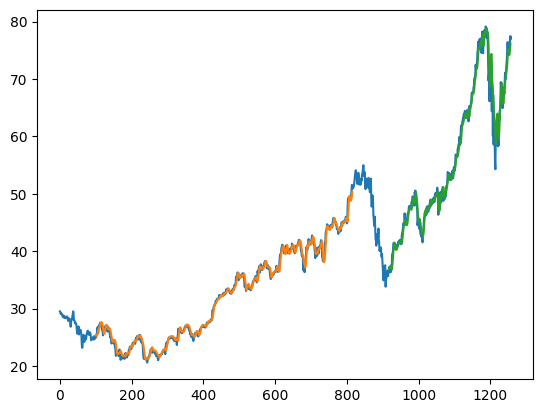

In [66]:
# Shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] =np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))              # Important
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [67]:
len(test_data)

441

In [68]:
# Taking last 100 days data ((len(test_data)-look_back) which is 441-100 = 341
x_input = test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [69]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [80]:
from numpy import array


lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

# Predicting next 30 days stock price
while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output) 

0 day input [0.99037219 0.99070276 0.96611672 0.98520719 0.97148833 0.94153081
 0.88008624 0.83835183 0.85723556 0.77818848 0.77752721 0.88268947
 0.84347551 0.89892878 0.85835162 0.84227746 0.74781723 0.82702959
 0.78608054 0.67368728 0.79657661 0.64881187 0.69281894 0.66724113
 0.65943151 0.59521863 0.5750952  0.668109   0.66248934 0.7158761
 0.67166262 0.70087662 0.69872786 0.64344019 0.66005126 0.64550612
 0.73252869 0.71996682 0.74740415 0.75533779 0.77707255 0.83409563
 0.82326964 0.83260794 0.8165343  0.79227922 0.75690786 0.78884892
 0.78442783 0.8172365  0.81806344 0.79909629 0.83690533 0.86198761
 0.84244248 0.8593428  0.87752447 0.89020978 0.90306063 0.93293394
 0.95315324 0.93823751 0.92265842 0.93048961 0.92290739 0.95294586
 0.94540535 0.97063792 0.96077692 0.96922897 0.96278811 0.96278811
 0.96278811 0.96278811 0.96278811 0.96278811 0.96278811 0.96278811
 0.96278811 0.96278811 0.96278811 0.96278811 0.96278811 0.96278811
 0.96278811 0.96278811 0.96278811 0.96278811 0.9627

In [81]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [82]:
len(df1)

1258

In [83]:
df3 = df1.tolist()
df3.extend(lst_output)

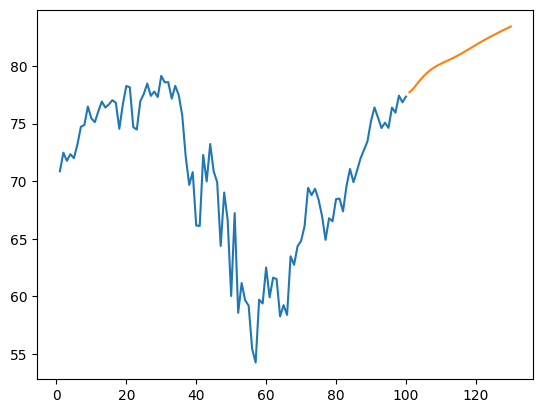

In [84]:
import matplotlib.pyplot as plt
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

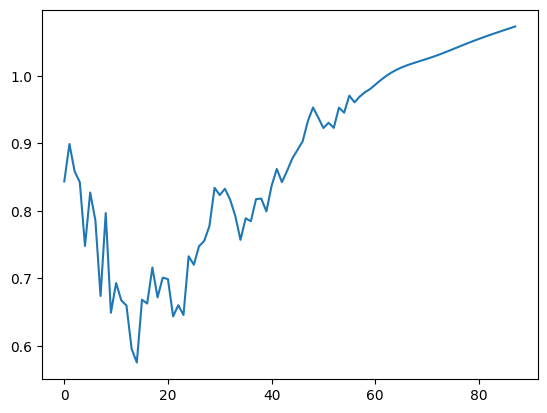

In [86]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])